In [1]:
import numpy as np # 处理linear algebra的package
import pandas as pd # 数据处理

import matplotlib #可视化
import matplotlib.dates as mdates #可视化
import matplotlib.pyplot as plt #可视化
import matplotlib.colors #可视化
import seaborn as sns #高级可视化

from textwrap import wrap #文本的自动换行和填充

%matplotlib inline
import warnings
warnings.filterwarnings("ignore") #忽视错误提示
#print(os.listdir("../input"))

import datetime as dt

from fastai.text.all import * # fastai框架

# 设定像素和视图的尺寸
plt.rcParams['figure.dpi'] = 150
plt.rcParams["font.family"] = "monospace"

1. 我们暂时没有足够相关的comments，所以先调用FastAI框架来处理疫苗相关的tweets情感分析,来检验我们模型的效果。

2. 在这个过程中我们也会做一些实验，去随机生成一些tweets，去观察模型的好坏。

3. 我们也想通过时间这个维度去观察大家情感的变化。以及针对不同的group大家的情感分布，在这里，我们先用不同的疫苗类型代替。(J&J, Pfizer etc)

In [39]:
vaccine_tweets = pd.read_csv('C:/Users/dadia/Desktop/FastAI/vaccination_all_tweets.csv')
tweets = pd.read_csv('C:/Users/dadia/Desktop/FastAI/tweet_dataset.csv')

# 数据和处理过程

In [40]:
# vaccine_tweets.shape

In [41]:
vaccine_tweets.head(5) #瞅一眼testing data

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                                                                                                                    user_description  \
0                                   Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻   
1            Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.   
2                                                                                                                                     heil, hydra 🖐☺   
3  Hosting "CharlesAdlerTonight" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca   
4                Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views   

          user_created  user_followers  user_friends  user_favourites  \
0  2009-04-08 17:52:46             405          1692             3247   
1  2009-09-21 15:27:30             834           666              178   
2  2020-06-25 23:30:28              10            88              155   
3  2008-09-10 11:28:53           49165          3933            21853   
4  2020-04-23 17:58:42             152           580             1473   

   user_verified                 date  \
0          False  2020-12-20 06:06:44   
1          False  2020-12-13 16:27:13   
2          False  2020-12-12 20:33:45   
3           True  2020-12-12 20:23:59   
4          False  2020-12-12 20:17:19   

                                                                                                                                           text  \
0                                             Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF   
1  While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P   
3  Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4   
4       Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq   

                                                                              hashtags  \
0                                                                   ['PfizerBioNTech']   
1                                                                                  NaN   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']   
3                                                                                  NaN   
4                                       ['whereareallthesickpeople', 'PfizerBioNTech']   

                source  retweets  favorites  is_retweet  
0  Twitter for Android         0          0       False  
1      Twitter Web App         1          1       False  
2  Twitter for Android         0          0       False  
3      Twitter Web App       446       2129       False  
4   Twitter for iPhone         0          0       False

In [42]:
tweets.head(5) #瞅一眼training data

textID   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                                                                text  \
0   i know  i was listenin to bad habit earlier and i started freakin at his part =[   
1                       Layin n bed with a headache  ughhhh...waitin on your call...   
2                                                Funeral ceremony...gloomy friday...   
3                                               wants to hang out with friends SOON!   
4            We want to trade with someone who has Houston tickets, but no one will.   

                                                                                       old_text  \
0  @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[   
1                                  Layin n bed with a headache  ughhhh...waitin on your call...   
2                                                           Funeral ceremony...gloomy friday...   
3                                                          wants to hang out with friends SOON!   
4        @dannycastillo We want to trade with someone who has Houston tickets, but no one will.   

        aux_id new_sentiment  \
0  p1000000000           NaN   
1   c811396dc2      negative   
2   9063631ab1      negative   
3   2a815f151d      positive   
4   82565a56d3       neutral   

                                                             selected_text  
0                                                                      NaN  
1                                                                 headache  
2                                                                   gloomy  
3                                     wants to hang out with friends SOON!  
4  We want to trade with someone who has Houston tickets, but no one will.

In [50]:
# #训练数据中一共出现了13种情感类型，我们尽可能的还原这些结果到我们的模型中。目前先用三种分类
# list1 = tweets['sentiment']
# unique_list = []
# for x in list1:
#     if x not in unique_list:
#         unique_list.append(x)
# print(unique_list)

In [44]:
tweets.isnull().sum()

textID               0
sentiment            0
author               0
text                66
old_text             0
aux_id               0
new_sentiment     8605
selected_text    12233
dtype: int64

In [45]:
# 虽然但是，我们需要把用户输入的表情删掉，目前没有办法去甄别所有表情，之后我们可以加库，自己手动进行添加。
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# 清洗掉所有的符号或者没有意义的编码，比如我们看到的http链接等等，这个过程可以根据我们本身的data进行修改。
def tweet_cleaner(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']

In [46]:
# 不重要，改下名字方便记忆。
tweets = tweets[['old_text','new_sentiment']].rename(columns={'old_text':'text','new_sentiment':'sentiment'})

# 在testing data里加一个column，这个就是我们将来做预测的地方。
vaccine_tweets['sentiment'] = np.nan

# 把之前的清洗工作完成。
tweets = tweet_cleaner(tweets)
vaccine_tweets = tweet_cleaner(vaccine_tweets)

# 启动FastAI

In [48]:
# dataframe
df_lm = tweets[['text', 'sentiment']].append(vaccine_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))

109642 31323


In [51]:
df_clas['sentiment'].value_counts() #training数据的结果

neutral     12596
positive     9897
negative     8830
Name: sentiment, dtype: int64

# 创建我们自己的语言模型

In [52]:
dls_lm = TextDataLoaders.from_df(df_lm,
                                 text_col='text',
                                 is_lm=True, 
                                 valid_pct=0.1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


Let's look at what we've created so far

In [54]:
dls_lm.show_batch(max_n=3)

## 方便大家理解为鸡毛这么多XX什么什么的
##### UNK (xxunk) is for an unknown word (one that isn’t present in the current vocabulary)
##### BOS (xxbos) represents the beginning of a text in your dataset
##### FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor 4 to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
##### TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
##### TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
##### TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
##### TK_WREP (xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [58]:
# 评估体系
learn = language_model_learner(
    dls_lm, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [59]:
learn.fit_one_cycle(1, 2e-2)

In [60]:
learn.save('1epoch')#模型开启 的时候差不多要46分钟，所以我们先把模型存起来

Path('models/1epoch.pth')

上面我们用了fastal预设的学习率，现在我们尝试去优化

SuggestedLRs(valley=0.0002290867705596611)

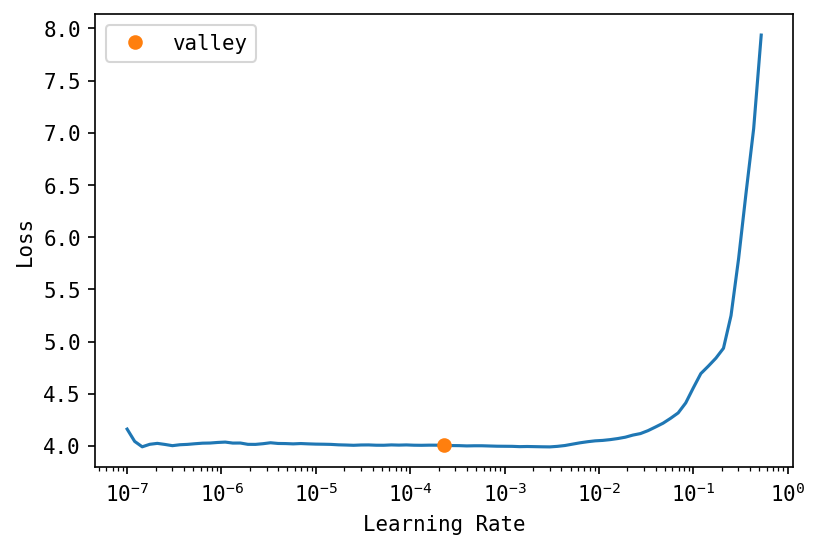

In [61]:
learn.unfreeze() 
learn.lr_find()

我们需要损失函数(Loss)在下降阶段，但是不能太接近上升开始的点（10^-1）
大黄点是优化的最优解

In [62]:
learn.fit_one_cycle(5, 1e-4)

KeyboardInterrupt: 

因为之前我们至启用了一个epoch,这次我们尝试更多epoch去提升准确率

In [63]:
learn.save('model2')

learn.save_encoder('model_finetuned')

我们没有储存模型的最后一层layer，以方便我们自己DIY

下面可以尝试用模型去预测我们要表达的意思

In [86]:
Text = "The vaccine"
Number_of_words = 15     # 每句话的字数限制
Number_of_sentences = 2  # 生成多少个案例
preds = [learn.predict(Text, Number_of_words, temperature=0.75) # 增加一个随机值，这样模型不会每次给的都是同一个答案
         for _ in range(Number_of_sentences)]

print("\n".join(preds))

TypeError: predict() got an unexpected keyword argument 'temperature'

# 分类器的DIY

In [73]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(df_clas, bs=128, seq_len=72)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [74]:
dls_clas.show_batch(max_n=3)

In [75]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [76]:
learn = learn.load_encoder('model_finetuned')

# 调优分类器（一定不能同时unfreeze所有的layer,需要一层一层的往下unfreeze）

In [79]:
learn.fit_one_cycle(1, 2e-2)

unfreeze模型，除了最后两层

In [87]:
learn.freeze_to(-2) #最后两层layer
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

Unfreeze最后两层再跑一边

In [88]:
learn.freeze_to(-3) #三层layer同时释放
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

Unfreeze所有模型

In [89]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

In [90]:
learn.save('final_classifier')

Path('models/final_classifier.pth')

# 到这一步，我们有了准确率，目标是76%

In [91]:
predictions_dl = dls_clas.test_dl(vaccine_tweets['text'])
predictions = learn.get_preds(dl=predictions_dl)

In [92]:
predictions

(tensor([[0.4924, 0.3991, 0.1085],
         [0.0730, 0.2062, 0.7208],
         [0.0522, 0.8899, 0.0579],
         ...,
         [0.2557, 0.6162, 0.1281],
         [0.0724, 0.8931, 0.0345],
         [0.0923, 0.4155, 0.4922]]),
 None)

In [93]:
predictions[0].argmax(dim=-1)

tensor([0, 2, 1,  ..., 1, 1, 2])

开始预测testing data

In [94]:
vaccine_tweets['sentiment'] = predictions[0].argmax(dim=-1)

vaccine_tweets['sentiment'] = vaccine_tweets['sentiment'].map({0:'Negative', 1:'Neutral', 2:'Positive'})

vaccine_tweets['Date'] = pd.to_datetime(vaccine_tweets['date'], errors='coerce').dt.date

vaccine_tweets.to_csv('vaccine_tweets.csv') #暂时把结果存起来

# 发掘结果

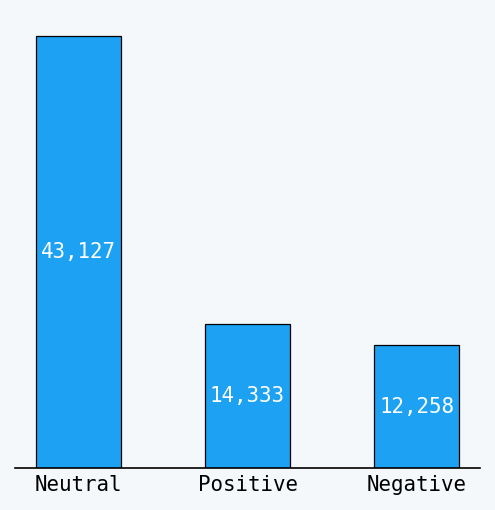

In [102]:
fig = plt.figure(figsize=(4, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

vaccine_tweets['Count'] = 1
temp = vaccine_tweets.groupby('sentiment')['Count'].sum().sort_values(ascending=False)

ax0.bar(temp.index, temp, width=0.5, edgecolor='black',linewidth=0.6, color='#1da1f2')

for i in temp.index:
    ax0.annotate(f"{format(round(temp[i]), ',')}", xy=(i, temp[i]/2),color='white', va='center', ha='center', fontweight='light')

ax0.grid(axis='y', linestyle='-', alpha=0.4)   
ax0.set_yticks([])
ax0.tick_params(axis=u'both', which=u'both',length=0)

for s in ['top', 'left', 'right']:
    ax0.spines[s].set_visible(False)


plt.show()

In [105]:
# 处理时间信息
vaccine_tweets['date'] = pd.to_datetime(vaccine_tweets['date'], errors='coerce')
vaccine_tweets['date'] = pd.to_datetime(vaccine_tweets["date"].dt.strftime('%Y-%m-%d'))
vaccine_tweets['Year'], vaccine_tweets['Month'], = vaccine_tweets['date'].dt.year, vaccine_tweets['date'].dt.month

In [106]:
temp1 = vaccine_tweets.groupby(['date', 'sentiment'])['Count'].count().reset_index().dropna()
temp2 = pd.pivot_table(temp1, index='date',columns='sentiment',values='Count',aggfunc=np.sum, fill_value=0)

可以查看一下随着时间的推移，情绪的变化

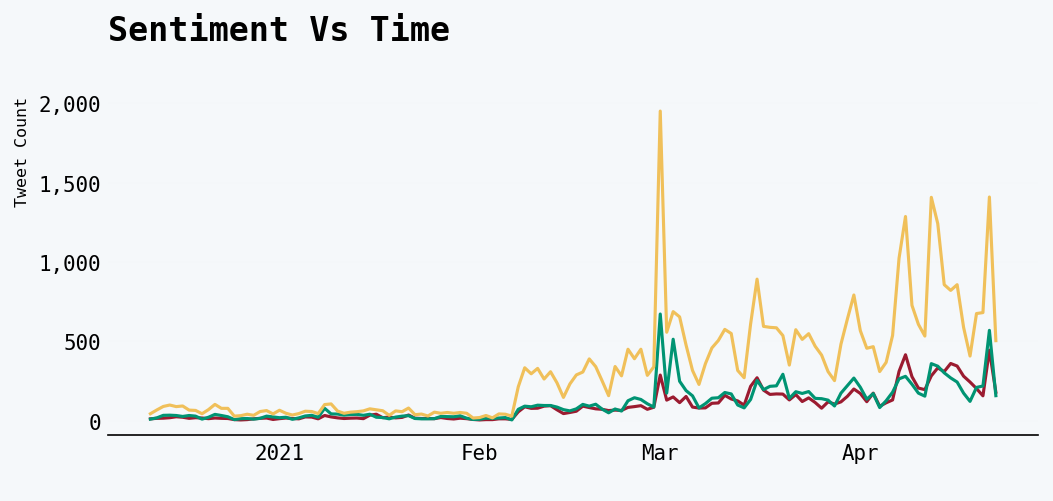

In [110]:
fig = plt.figure(figsize=(8, 3), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

colors = ['#9b1b30', '#009473', '#f0c05a']

color_num = 0
for i in ["Negative", "Positive", "Neutral"]:
    sns.lineplot(data=temp2[i], x=temp2.index, y=temp2[i], color=colors[color_num], ax=ax0)
    color_num += 1
    
ax0.grid(axis='y', linestyle='-', alpha=0.01)   
#ax0.set_yticks([])
ax0.tick_params(axis=u'both', which=u'both',length=0)

for s in ['top', 'left', 'right']:
    ax0.spines[s].set_visible(False)
    
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel("Tweet Count",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(formatter)

ax0.text(Xstart,2400,'Sentiment Vs Time',fontweight='bold', fontsize=16, zorder=20)


plt.show()

# Oxford
针对 Oxford


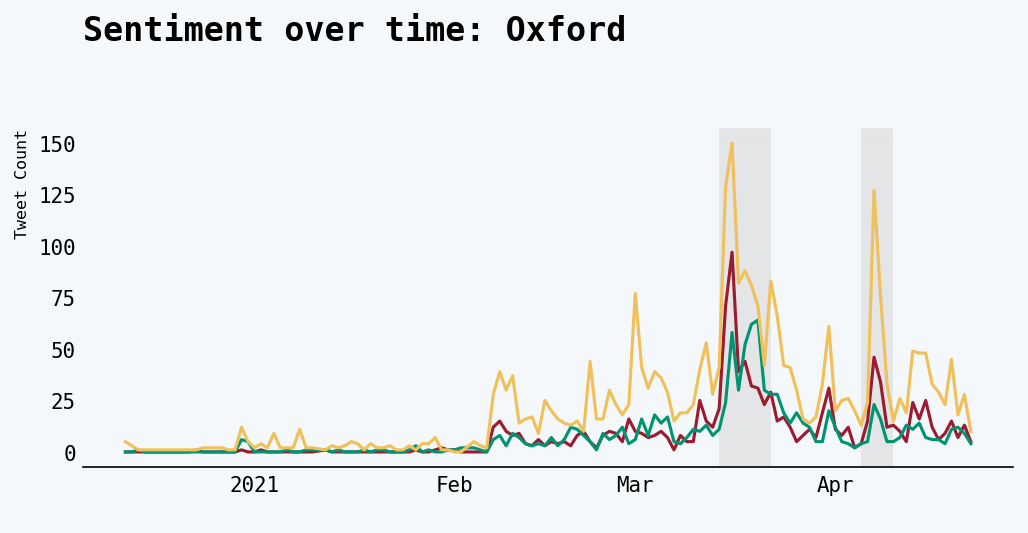

In [114]:
astra = (vaccine_tweets[vaccine_tweets['orig_text'].str.lower().str.contains('astra')])
temp1 = astra.groupby(['date', 'sentiment'])['Count'].count().reset_index().dropna()
temp2 = pd.pivot_table(temp1, index='date',columns='sentiment',values='Count',aggfunc=np.sum, fill_value=0)

fig = plt.figure(figsize=(8, 3), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

colors = ['#9b1b30', '#009473', '#f0c05a']


color_num = 0
for i in ["Negative", "Positive", "Neutral"]:
    sns.lineplot(data=temp2[i], x=temp2.index, y=temp2[i], color=colors[color_num], ax=ax0)
    color_num += 1
    
ax0.grid(axis='y', linestyle='-', alpha=0.01)   
#ax0.set_yticks([])
ax0.tick_params(axis=u'both', which=u'both',length=0)

for s in ['top', 'left', 'right']:
    ax0.spines[s].set_visible(False)
    
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel("Tweet Count",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(formatter)

ax0.text(Xstart,200,'Sentiment over time: Oxford',fontweight='bold', fontsize=16, zorder=20)

ax0.axvspan(18700, 18708, facecolor='lightgray',alpha=0.5)

ax0.axvspan(18722, 18727, facecolor='lightgray',alpha=0.5)    

plt.show()

In [115]:
temp2['Neut_%'] = temp2['Neutral'] / (temp2['Neutral'] + temp2['Negative'] + temp2['Positive'] )
temp2['Neg_%'] = temp2['Negative'] / (temp2['Neutral'] + temp2['Negative'] + temp2['Positive'] )
temp2['Pos_%'] = temp2['Positive'] / (temp2['Neutral'] + temp2['Negative'] + temp2['Positive'] )

# optional发现一种新的可视方法

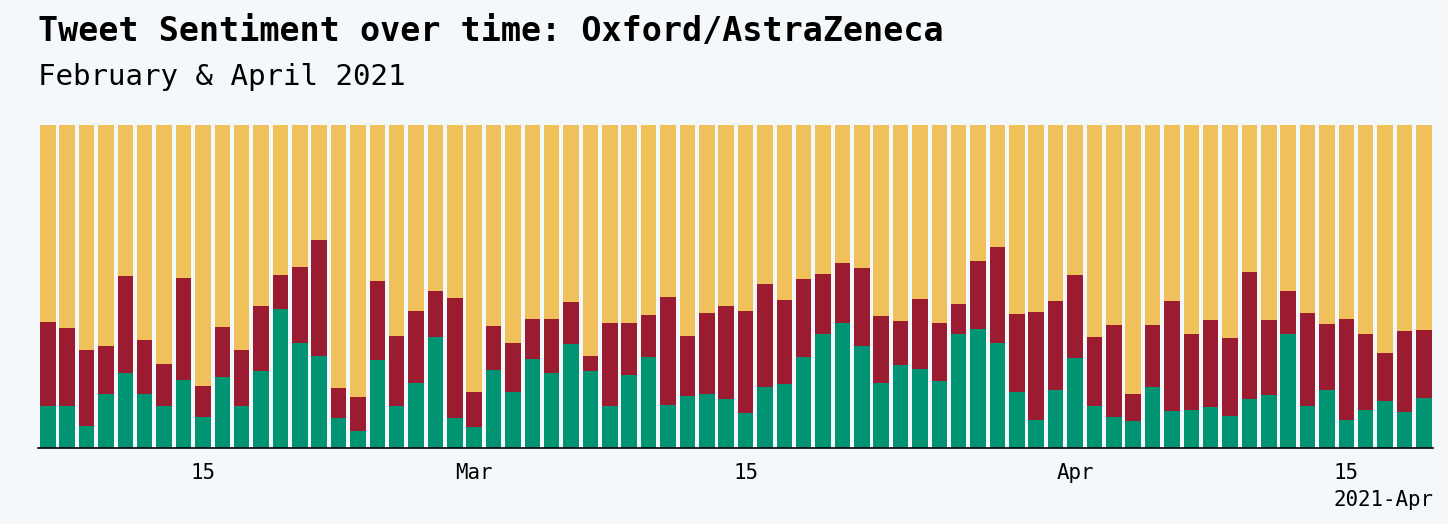

In [117]:
fig = plt.figure(figsize=(12, 3), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

Neg_col = '#9b1b30'
Pos_col = '#009473'
Neut_col = '#f0c05a'

color = [Neut_col, Neg_col, Pos_col]

astra_temp = astra.groupby('sentiment')['date'].value_counts().unstack().fillna(0).loc[['Positive','Negative','Neutral']].T
astra_all = astra_temp.sum(axis=1)
astra_temp = (astra_temp.T / astra_all).cumsum().T

for i, sents in enumerate(astra['sentiment'].value_counts().index):
    sentims = astra_temp[sents]
    ax0.bar(sentims.index, sentims, color=color[i], label=sents)
    
for s in ['top', 'right', 'left']:
    ax0.spines[s].set_visible(False)

ax0.set_yticks([])

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel(" ",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(formatter)

ax0.text(Xstart+63.5,1.26,'Sentiment over time: Oxford',fontweight='bold', fontsize=16, zorder=20)
ax0.text(Xstart+63.5,1.125,'February & April 2021',fontweight='light', fontsize=14, zorder=20)

ax0.set_xlim(Xstart+63.5,Xend-9.5)

plt.show()

# 我们可以不关注中立的情绪，因为没用

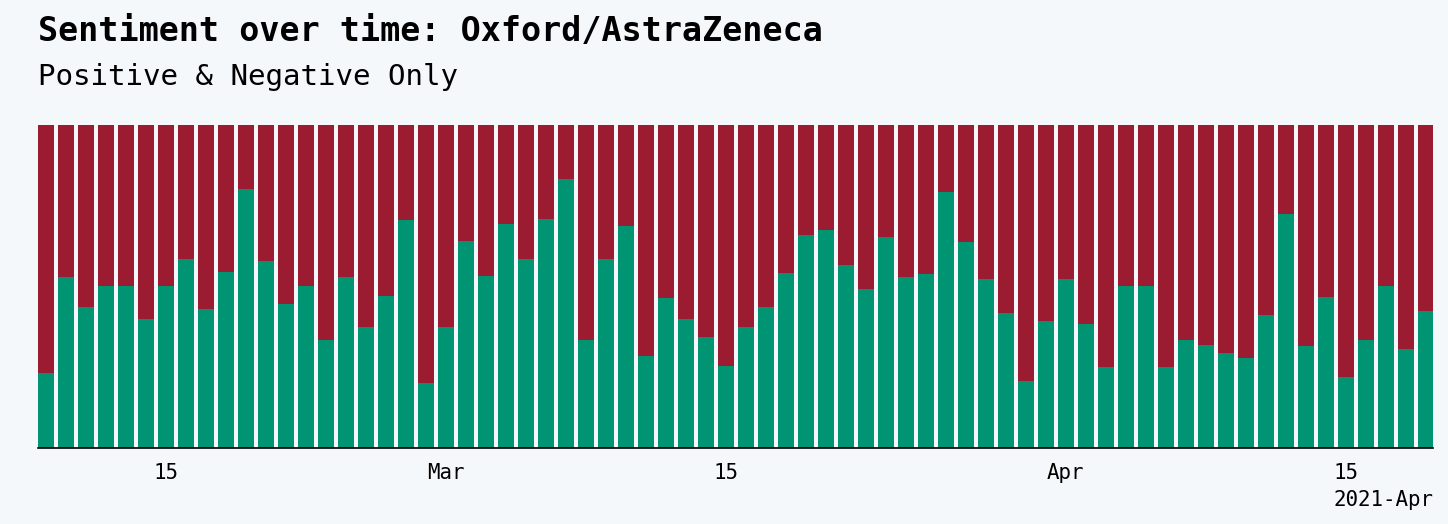

In [119]:
fig = plt.figure(figsize=(12, 3), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

Neg_col = '#9b1b30'
Pos_col = '#009473'

color = [Neg_col, Pos_col]

neg_pos = astra[(astra['sentiment'] == 'Positive')  | (astra['sentiment'] == 'Negative')]
astra_temp = neg_pos.groupby('sentiment')['date'].value_counts().unstack().fillna(0).loc[['Positive','Negative']].T
astra_all = astra_temp.sum(axis=1)
astra_temp = (astra_temp.T / astra_all).cumsum().T

for i, sents in enumerate(neg_pos['sentiment'].value_counts().index):
    sentims = astra_temp[sents]
    ax0.bar(sentims.index, sentims, color=color[i], label=sents)
    
for s in ['top', 'right', 'left']:
    ax0.spines[s].set_visible(False)

ax0.set_yticks([])

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.set_ylabel(" ",fontsize=8,loc='top', fontfamily='monospace')
ax0.set_xlabel(" ",fontsize=8,loc='left', fontfamily='arial')
ax0.tick_params(axis = "both", which = "both", left=False, bottom=False)
ax0.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(formatter)

ax0.text(Xstart+63.5,1.26,'Sentiment over time: Oxford/AstraZeneca',fontweight='bold', fontsize=16, zorder=20)
ax0.text(Xstart+63.5,1.125,'Positive & Negative Only',fontweight='light', fontsize=14, zorder=20)

ax0.set_xlim(Xstart+63.5,Xend-9.5)

plt.show()